In [2]:
from jax import numpy as jnp, random, jit
import thermox
from time import time
import matplotlib.pyplot as plt

We want to simulate an OU process
$$
dx = -A(x-b)dt + \mathcal{N}(0, Ddt)
$$
and compare `thermox` with and without an associative scan. This enables one to parallelize the time steps the solver takes, and have a complexity in $O(T/p + log(T))$ for $p$ cores and $T$ timesteps. 

In [3]:
# Define dimension
dim = 100

In [4]:
# Master key
key = random.PRNGKey(0)

In [5]:
# Function to generate a random wishart matrix
def sample_wishart(key, dim, df):
    G = random.normal(key, (dim, df))
    return G @ G.T

In [6]:
# Generate A from Wishart distribution
key, A_key = random.split(key)
df_A = 10
A = sample_wishart(A_key, dim, df_A)

# Perturb to ensure it is positive definite
A += 1e-3 * jnp.eye(dim)


In [7]:
# Generate x0 and b from normal distribution
key, x0_key, b_key = random.split(key, 3)
x0 = random.normal(x0_key, (dim,))
b = random.normal(b_key, (dim,))

In [8]:
# Identity D
D = jnp.eye(dim)
D_sqrt = jnp.linalg.cholesky(D)

In [9]:
# Function to simulate from thermox
@jit
def simulate_thermox(rk, ts):
    return thermox.sample(rk, ts, x0, A, b, D, associative_scan=False)

@jit
def simulate_thermox_as(rk, ts):
    return thermox.sample(rk, ts, x0, A, b, D, associative_scan=True)

The following script runs `thermox.sample` with and without associative scan, for up to 100 million time steps (takes about 1 minute to run).

In [10]:
# Time the two simulators
# T_range = [10, 100, 1000, 10000]
T_range = jnp.logspace(3, 7, 6)

# Init run for compilation
simulate_thermox(key, jnp.arange(2.)).block_until_ready()
simulate_thermox_as(key, jnp.arange(2.)).block_until_ready()

thermox_times = []
thermox_as_times = []

for T in T_range:
    print(f"Running for T={T}")
    ts = jnp.arange(0, T, 1.)

    # Thermox
    start = time()
    vals_t = simulate_thermox(key, ts).block_until_ready()
    end = time()
    thermox_times.append(end - start)
    
    # Thermox Associative Scan
    start = time()
    vals_as = simulate_thermox_as(key, ts).block_until_ready()
    end = time()
    thermox_as_times.append(end - start)
    

Running for T=1000.0
Running for T=6309.57275390625
Running for T=39810.70703125
Running for T=251188.421875
Running for T=1584892.5
Running for T=10000000.0


Let's visualise the runtimes

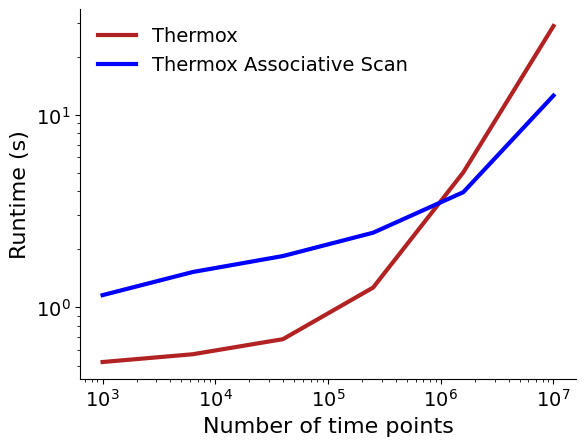

In [11]:
linewidth = 3
plt.plot(T_range, thermox_times, label="Thermox", color="firebrick", linewidth=linewidth)
plt.plot(T_range, thermox_as_times, label="Thermox Associative Scan", color="blue", linewidth=linewidth)

fontsize = 16
plt.xlabel("Number of time points", fontsize=fontsize)
plt.ylabel("Runtime (s)", fontsize=fontsize)

legend_fontsize = 14
plt.legend(frameon=False, fontsize=legend_fontsize)
plt.xscale("log")
plt.yscale("log")

ticks_fontsize = 14
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)


And there you have it! `thermox` is roughly constant with respect to the number of time points, because the computation is dominated by the diagonalisation that is performed at initialisation. For a small number of time points, performance is comparable, but `thermox` really starts to shine for $\sim 10000$ time steps, where we get $\sim 800\times$ speedup with respect to `diffrax`, as well as being exact!